# BAYa class Assignment 2020

In this assignment, your task will be to implement and analyze algorithms for inference in probabilistic
models described by factor graphs. In particular, you will implement Sum-Product algorithm (or Belief Propagation)
and Max-Product (Max-Sum) algorithm to infer different probabilities, (marginal) distributions and values of variables for general factor
graphs with categorical random variables as described in the slides on [Graphical Models and Inference](http://www.fit.vutbr.cz/study/courses/BAYa/public/prednasky/2-Graphical%20Models.pdf).
More detailed information can be found in Chapter 8.4 in [Christopher M. Bishop. 2006. Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)

The preferred and easiest way of accomplishing this task is to complete this Jupyter Notebook, which already comes
with a definition of the probabilistic model that you will work with.
If you do not have any experience with Jupyter Notebook, the easiest way to start is to install Anaconda3,
run Jupyter Notebook and open this notebook downloaded from [BAYa_Assignment2020.ipynb]
(http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/BAYa_Assignment2020.ipynb).

The following cell contains a code with the definition of the probabilistic model for which you will run the inference algorithms. You should not edit this part!

In [1]:
import numpy as np

#Names of random variables in our model
var_names=['State', 'Age', 'COVID', 'Party', 'Favorite', 'Voting']
           
#Names of possible values (categories) for each random variables.
val_names=[['Texas', 'California', 'NewYork'], #State
           ['Young', 'Old'],                   #Age
           ['Negative', 'Positive'],           #COVID
           ['Democrats', 'Republicans'],       #Party
           ['Biden', 'Trump'],                 #Favorite
           ['InPerson', 'Postal', 'NotVoting']]#Voting

#The above variables with names are introduced just to make up a story around our model. Use these names
# to interpret your results, but, in your 'generic' inference algirithms, avoid the use of these variables
# and use only the definitions below!

#Number of categories for each random variables.
ncategories = np.array([len(v) for v in val_names])

class Factor:
    """
    Instances of this class represent individual factors in a factor graph.
    It is merely a structure of two member variables:
    'vars': list of N integers, which are IDs of N random variables that this
        factor depends on. These integers can be seen as indices into 'var_names'
    'table': potential function of the factor. Since we deal only with categorical
        variables, the potential function has form of N-dimensional array.
        The first dimension corresponds to the first variable in 'vars', the second
        dimension to the second variable, etc. The size of each dimension is given
        by the number of possible values of the corresponding variable
    """
    def __init__(self, list_of_variable, potential_function_table):
        self.vars = list(list_of_variable)
        self.table = np.array(potential_function_table)
        
        # the number of table dimensions and the number of variables must match
        assert(self.table.ndim == len(self.vars))
        # the individual dimensions must match with the number of cathegories of the corresponding variable
        assert(np.all(ncategories[self.vars]==self.table.shape))

"List of factors defining our complete probabilistic model"
factors = [
#         P(State)
    Factor([0], [0.3,   # Texas
                 0.5,   # California
                 0.2]), # NewYork

#         P(Age)
    Factor([1], [0.6,   # Young
                 0.4]), # Old

#         P(COVID)
    Factor([2], [0.7,   # Negative 
                 0.3]), # Positive

#                               Texas      California  NewYork
#         P(Party|State,Age)   Young,Old   Young,Old   Young.Old
    Factor([3,    0,    1],  [[[0.4, 0.2], [0.9, 0.8], [0.8, 0.6]],  # Democrats 
                              [[0.6, 0.8], [0.1, 0.2], [0.2, 0.4]]]),# Republican

#         P(Favorite|Party)    Dem.  Rep.
    Factor([4,       3],     [[0.95, 0.2],  # Biden
                              [0.05, 0.8]]),# Trump
    
#                                Democrats   Republicans
#         P(Voting|Party,COVID) Neg. Pos.  Neg. Pos. 
    Factor([5,     3,    2], [[[0.5, 0.0], [0.7, 0.1]], # InPerson 
                              [[0.4, 0.9], [0.1, 0.4]], # Postal
                              [[0.1, 0.1], [0.2, 0.5]]])# None
]

In the above cell, we first introduce names of our random variables and their values to make up some "story" around our probabilistic model. Our model "pretends" to model the behaviour of a random US citizen during the recent US presidental elections. It contains the following random variables and their categorical values:

* State: Does the random person come from 'Texas', 'California' or 'NewYork'? For simplicity, we pretend that USA does not have more states.  
* Age: Is the person 'Young' or 'Old'?
* COVID: Is the person COVID 'Positive' or 'Negative'?
* Party: Is the person supporter of 'Democrats' or 'Republicans'?
* Favorite: Is the person's prefered president candidate 'Biden' or 'Trump'?
* Voting: Is the person voting 'InPerson', using 'Postal' vote or 'NotVoting' at all?

Next came the definition of the full model as a list of factors. In our model, the factors are taken from a bayesian network (see below). Therefore, each factor represents a (normalized) probability distribution for one of the 6 variables. Such variable is always the first element of 'vars' (see 'vars' in class Factor). If 'vars' has more than
one element, then the factor represents a conditional distribution that is conditioned on the remaining variables.

The following function 'evaluate_factor' can help us interpret the individual factors. Its arguments are a Factor  instance and values for all the variables that the factor depents on (in the order given by 'vars'). The values are given only as integer IDs of the categories (i.e. second indices into 'val_names') The function evaluates the factor using the values. Finally, using the variable and value names, it prints out a string showing what (conditional) distribution is evaluated using what values and what is the resulting probability.

In [3]:
def evaluate_factor(factor, *values):
    var_vals = ['='.join((var_names[var], val_names[var][val])) for var,val in zip(factor.vars, values)]
    print("P("+var_vals[0]+ ('' if len(var_vals)<2 else '|')+(','.join(var_vals[1:]))+") =", factor.table[values])

evaluate_factor(factors[5], 1, 0, 1)
evaluate_factor(factors[5], 2, 1, 1)
evaluate_factor(factors[4], 0, 1)
evaluate_factor(factors[0], 1)


P(Voting=Postal|Party=Democrats,COVID=Positive) = 0.9
P(Voting=NotVoting|Party=Republicans,COVID=Positive) = 0.5
P(Favorite=Biden|Party=Republicans) = 0.2
P(State=California) = 0.5


From the examples of evaluated factors above, we can see that
* 90% of COVID positive supporters of Democrats choose to vote using postal votes
* 50% of COVID positive Republicans choose not to vote at all
* 20% of Republicans find Biden to be more acceptable president
* 50% of voters are from California

Using all the factors, the following code construct graph showing the corresponding Bayesian Network. Each node is one variable. For each factor, we create edges into the first variable in 'vars' from all the remaining variables.

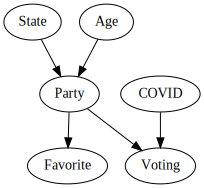

In [4]:
from graphviz import Digraph
dot = Digraph()
dot.edges([(var_names[v] ,var_names[f.vars[0]]) for f in factors for v in f.vars[1:]])
dot

As we can see, our model naively assumes that the probability of being COVID positive does not dependent
on the age or the state the person is from.

Similarly, we can draw Factor Graph corresponding to our model:

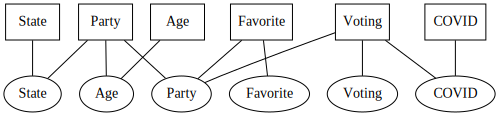

In [5]:
from graphviz import Graph
fg = Graph()
for f in factors:
    fg.node(var_names[f.vars[0]]+"_", var_names[f.vars[0]], shape="box")
fg.edges([(var_names[f.vars[0]]+"_" ,var_names[v]) for f in factors for v in f.vars])
fg

As was already said, each factor corresponds to (conditional) distribution of one variable. Therefore, we choose the factors (rectangle) node names to be these variables names. This Factor Graph has tree structure so application of Belief Propagation should be straightforward.

The following cell implements the inefficient 'brute-force marginalization' approach, which might be useful to test  correctness of your Belief Propagation implementation. When calling this function, we can specify values of some of the variables and the function marginalizes over all possible values of the remaining variables. It implements the operation
 $$
\DeclareMathOperator{\xx}{\mathbf{x}}
\sum_{\xx_{marg}}\prod_s f_s(\xx_s)
$$
where the product is over all factors $f_s$, $\xx_s$ is the subset of variables that $f_s$ depends on and $\xx_{marg}$ is the subset of variables for which the sum sums over all their possible values (i.e marginalizes). For our model where the factors are the (conditional) distributions of individual variables, the product corresponds to the joint distribution of all the variables
$$
\prod_s f_s(\xx_s) = P(State) P(Age) P(COVID) P(Party|State,Age) P(Favorite|Party) P(Voting|Party,COVID)\\
= P(State,Age,COVID,Party,Favorite,Voting)
$$

For example, if we supply the function with values for $Party$ and $Voting$ and marginalize over all other variables, we obtain the joint marginal probability


$$
P(Party,Voting)=\sum_{State} \sum_{Age}\sum_{COVID}\sum_{Favorite}P(State,Age,COVID,Party,Favorite,Voting)
$$

In [6]:
import itertools    
def brute_force_marginalize(value_list):
    """
    observed_values is a list of values one for each variable. For values set to None,
    we marginalize over all possible values of the corresponding variable. For other
    values, we use the given value for the corresponding variables when evaluating factors.
    """
    value_ranges = [range(n) if v is None else (v,) for n,v in zip(ncategories, value_list)]
    marginal_prob = 0.0
    # itertools.product let us iterate over all possible values of all variables
    for values in itertools.product(*value_ranges):
        joint_prob = 1.0
        for f in factors:
           joint_prob *= f.table[tuple(values[v] for v in f.vars)]
        marginal_prob+=joint_prob
    return marginal_prob

print("Z = ", brute_force_marginalize([None, None, None, None, None, None]))


Z =  0.9999999999999999


When calling 'brute_force_marginalize' in the cell above, we set the values of all variables to 'None'. This instructs the function to sum over all the values of all the variables. The result is 1, which proves that our model represents a well normalized joint distribution. In the following calls, we clamp some of the variables to specific values, which avoids marginalization over those variables.

In [8]:
print("P(Voting=InPerson)  =", brute_force_marginalize([None, None, None, None, None, 0]))
print("P(Voting=Postal)    =", brute_force_marginalize([None, None, None, None, None, 1]))
print("P(Voting=NotVoting) =", brute_force_marginalize([None, None, None, None, None, 2]))
print("P(Party=Democrats)  =", brute_force_marginalize([None, None, None, 0, None, None]))
print("P(Party=Republicans)=", brute_force_marginalize([None, None, None, 1, None, None]))
print("P(Party=Republicans,Voting=InPerson)=", brute_force_marginalize([None, None, None, 1, None, 0]))

P(Voting=InPerson)  = 0.4061000000000001
P(Voting=Postal)    = 0.43120000000000014
P(Voting=NotVoting) = 0.1627
P(Party=Democrats)  = 0.6699999999999997
P(Party=Republicans)= 0.33000000000000024
P(Party=Republicans,Voting=InPerson)= 0.17159999999999995


The above examples show that the marginal probabilities $P(Voting)$ and $P(Party)$ sum to 1 when summed over all their possible values. The marginal distribution $P(Voting)$ tells us what are the probabilities of different forms of voting (InPerson, Postal, NotVoting) and $P(Party=Democrats)$ says that $2/3$ of all the people are Democrats. 

We also evaluate the joint marginal P(Party,Voting) to see that out of all the people, 17.16% are Republicans that came to vote InPerson.

# Tasks and Questions
Your task is to implement the Sum-Product algorithm allowing for much more efficient inference that the brute-force approach. Based on the following questions, you will use the algorithm to infer individual probabilities such as
$$P(Age=Young,Favorite=Biden)=?$$
$$P(Voting=Postal|Favorite=Trump,COVID=Positive)=?$$
or the whole marginal distributions such as
$$P(Voting|Favorite=Trump,COVID=Positive)=?$$
$$P(Age,Favorite)=?$$
For the distributions, you need to report probabilities for all the possible values of the variables in question, e.g.
$$P(Age=Young,Favorite=Biden)=?$$
$$P(Age=Young,Favorite=Trump)=?$$
$$P(Age=Old,Favorite=Biden)=?$$
$$P(Age=Old,Favorite=Trump)=?$$

Use your implementation to infer the following probabilities or distributions and to answer the following question:

1. For all the individual variables, use the Sum-Product algorithm to (most efficiently) infer and print their marginal distributions $P(State)$, $P(Age)$, $P(COVID)$, $P(Party)$, $P(Favorite)$, $P(Voting)$.
2. What is the computational complexity of the inference from the previous point compared to the brute-force marginalization? Extend the code for the inference algorithms (both brute-force and Sum-Product) to count the number of additions and multiplications carried out during the inference (consider only those from the equations describing the algorithm). Report these number. Note that, with the brute-force approach you need to call the brute_force_marginalize once for every value of every variable in order to evaluate all the marginal distributions. Keep reporting such computational complexity comparisons also for all the following inference problems.
3. Use the Sum-Product algorithm to evaluate and print the following conditional marginal distributions
$$P(Voting|Favorite=Trump)$$
$$P(Voting|Favorite=Trump,COVID=Positive)$$
$$P(Voting|Favorite=Trump,State=Texas,COVID=Positive)$$
4. Use the Sum-Product algorithm to (most efficiently) evaluate and print the following joint marginal distribution
$$P(Party, Favorite)$$
Hint: Note that there is one factor dependent on both these variables.
5. Use the Sum-Product algorithm to evaluate and print the following joint marginal probability
$$P(Party=Republicans,Voting=InPerson)$$
6. How can we use the Sum-Product algorithm to evaluate the whole joint marginal distribution $P(Party,Voting)$?
Note that in this case, there is no factor dependent on both these variables.
7. Implement Max-Product (or Max-Sum) algorithm and use it to infer the most likely values of all the variables. In other words, find the values for all the variables that maximizes the joint probability
$$P(State, Age, COVID, Party, Favorite, Voting)$$
8. With observed values $Voting=Postal$ and $Favourite=Trump$, .use Max-Product (or Max-Sum) algorithm find the most likely values of all the remaining variables. 
9. Finally, what if we replace factor `Factor([2], [0.3, 0.7])` in our model with factor `Factor([2, 0], [[0.9, 0.8, 0.5], [0.1, 0.2, 0.5]])`? What does it represent? How does the corresponding Bayesian Network change? How does it complicate the inference? It is enought if you just answer these questions. You can also try to implement inference for the marginals of the individual variables for this modified model. Succesfull implementation will be awarded by a bonus point.